# Experiments in Issue Segmentation

### Load Libraries and Datasets

In [5]:
import os
import pandas as pd
import altair as alt
alt.data_transformers.disable_max_rows()
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import sys

sys.path.append("..")
from compute_magazines.scripts.load_datasets import *
from compute_magazines.scripts.classifier_magazines import *

In [6]:
output_path = '../datasets/ht_ef_datasets/full_hathitrust_annotated_magazines_with_htids.csv'
output_directory = "../datasets/ht_ef_datasets/"
full_issues = get_full_combined_dataset(output_path, output_directory)

In [7]:
full_issues.htid.value_counts()

uiug.30112070958894    363936
mdp.39015056038071     300895
mdp.39015056038386     297294
txu.059172014718818    283215
mdp.39015056038212     276891
                        ...  
mdp.39015083020449      13818
inu.32000013032836      13401
uc1.l0082986993         11685
inu.32000013032828      11131
uc1.b4952555            10575
Name: htid, Length: 88, dtype: int64

In [8]:
# full_links_df = pd.read_csv("../original_files/htrc_third_world_records_links_with_metadata.csv")

### Extract Digits

In [9]:
def clean_digits(df):
    df.token = df.token.astype(str)
    if 'volume_name' in df.columns.tolist():
        df.volume_number = df.volume_number.fillna(0)
    subset_digits = df[(df.token.str.isdigit()) ]
    subset_digits['number'] = subset_digits.token.astype(int)
    subset_digits['implied_zero'] = subset_digits.sequence.astype(int) - subset_digits.number
    return subset_digits

In [10]:
def get_predicted_page(df, range_of_max_issue_length):
    dfs = []
    for max_issue_length in range_of_max_issue_length:
        copied_df = df.copy()
        max_page = copied_df.sequence.max()
        max_possible_number = max_page + max_issue_length
        filtered_df = copied_df[copied_df.number < max_possible_number]
        grouped_pages = filtered_df.groupby('implied_zero').size().reset_index(name='counts')
        grouped_pages = grouped_pages[grouped_pages.counts > max_issue_length - 5]
        grouped_pages = grouped_pages.reset_index(drop=True)
        copied_df['predicted_page'] = None
        copied_df['predicted_issue_number'] = None
        copied_df['max_issue_length'] = max_issue_length
        
        for index, row in grouped_pages.iterrows():
            zero_window = [row.implied_zero -2, row.implied_zero + 2]
            zero_window = [max(0, x) for x in zero_window]
            for count in range(zero_window[0], zero_window[1]):
                copied_df.loc[(copied_df.sequence == count), 'predicted_page'] = 'predicted_beginning_of_issue'
                copied_df.loc[(copied_df.sequence == count), 'predicted_issue_number'] = f"issue {index}"
        dfs.append(copied_df)
    combined_df = pd.concat(dfs)
    return combined_df

In [11]:
### Annotated Datasets

def get_annotated_datasets(df, range_of_max_issue_length, rewrite_files):
       predictions_path = "../issue_segments/predicted_issue_segments_for_annotated_issues.csv"
       issues_path = "../derived_annotated_datasets/issue_segments_for_annotated_issues.csv"
       if (os.path.exists(predictions_path)) and (os.path.exists(issues_path)) and (rewrite_files == False):
              predictions = pd.read_csv(predictions_path)
              final_df = pd.read_csv(issues_path)
       else:
              subset_digits = clean_digits(df)
              tqdm.pandas()
              htids = subset_digits.htid.unique().tolist()
              dfs = []
              for htid in tqdm(htids, total=len(htids), desc='Processing digits'):
                     subset_df = subset_digits[subset_digits.htid == htid]
                     subset_df = get_predicted_page(subset_df, range_of_max_issue_length)
                     dfs.append(subset_df)
              combined_subset_digits = pd.concat(dfs)
              combined_subset_digits = combined_subset_digits.reset_index(drop=True)
              digit_cols = combined_subset_digits.columns.tolist()
              digit_cols = [x for x in digit_cols if x not in ['pos', 'count', 'section', 'token']]
              combined_subset_digits = combined_subset_digits[digit_cols]
              cols = list(set(df) & (set(combined_subset_digits)))

              merged_df = pd.merge(df, combined_subset_digits, on=cols, how='left')
              if merged_df['volume_number'].isna().all():
                     merged_df = merged_df.drop(columns='volume_number')
              pages_cols = merged_df.columns.tolist()
              holdout_cols = ['sequence', 'section', 'token', 'pos', 'count', 'number', 'implied_zero']
              pages_cols = [x for x in pages_cols if x not in holdout_cols]
              pages_df = merged_df[pages_cols]
              pages_df = pages_df.drop_duplicates()
              groupby_cols = ['cleaned_magazine_title', 'ht_generated_title', 'volume_number', 'htid', 'hdl_link','cleaned_volume', 'start_issue', 'end_issue', 'datetime','dates', 'issue_number', 'type_of_page', 'sequence'] if 'volume_number' in merged_df.columns else ['cleaned_magazine_title', 'ht_generated_title', 'htid', 'hdl_link','cleaned_volume', 'start_issue', 'end_issue', 'datetime','dates', 'issue_number', 'type_of_page', 'sequence']
              final_df = merged_df.groupby(groupby_cols, as_index = False).agg({'token': ' '.join, 'count': list, 'number': list, 'implied_zero': list})
              final_cols = list(set(pages_df) & set(final_df))
              finalized_df = pd.merge(pages_df, final_df, on=final_cols, how='left')
              predictions = finalized_df[finalized_df.predicted_page.notna()]
              # predictions.to_csv(predictions_path, index=False)
              # finalized_df.to_csv(issues_path, index=False)
       return finalized_df, predictions

In [12]:
initial_df = full_issues[full_issues.htid == 'uiug.30112070958894']
range_of_max_issue_length = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 200, 300]

In [13]:
annotated_df, predictions = get_annotated_datasets(initial_df, range_of_max_issue_length, rewrite_files=True)

Processing digits: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


In [14]:
len(annotated_df[annotated_df.predicted_page.notna()]), len(predictions)

(14657, 14657)

### older code

In [18]:
import subprocess

In [17]:
data = annotated_df[annotated_df.predicted_page.notna()][0:1].to_dict()

In [30]:
annotated_df[(annotated_df.predicted_page.notna()) & (annotated_df.type_of_page == 'cover_page')][['cleaned_magazine_title', 'ht_generated_title', 'htid', 'hdl_link',
       'cleaned_volume', 'issue_number', 'dates', 'type_of_page', 'notes',
       'start_issue', 'end_issue', 'datetime', 'predicted_page',
       'predicted_issue_number', 'max_issue_length', 'sequence', 'token',]][0:1].token.values[0]

"! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LRB- -LSB- -LSB- -LSB- -LSB- -LSB- -LSB- -LSB- -LSB- -LSB- -LSB- -LSB- -LSB- -LSB- -LSB- -LS

In [19]:
subprocess.run("pbcopy", text=True, input=str(data))

CompletedProcess(args='pbcopy', returncode=0)

In [206]:


import sys

# Get size and memory usage of predictions dataframe
print("Size of predictions dataframe:", predictions.shape)
print("Memory usage of predictions dataframe:", predictions.memory_usage(deep=True).sum())


Size of predictions dataframe: (14657, 20)
Memory usage of predictions dataframe: 10276603757


In [214]:
for col in predictions.columns.tolist():
    predictions[col] = predictions[col].astype('str')


In [215]:
predictions[['cleaned_magazine_title', 'ht_generated_title', 'htid', 'hdl_link',
       'cleaned_volume', 'issue_number', 'dates', 'type_of_page', 'notes',
       'start_issue', 'end_issue', 'datetime', 'predicted_page',
       'predicted_issue_number', 'max_issue_length', 'sequence', 'token',]].info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14657 entries, 562 to 47109
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   cleaned_magazine_title  14657 non-null  object
 1   ht_generated_title      14657 non-null  object
 2   htid                    14657 non-null  object
 3   hdl_link                14657 non-null  object
 4   cleaned_volume          14657 non-null  object
 5   issue_number            14657 non-null  object
 6   dates                   14657 non-null  object
 7   type_of_page            14657 non-null  object
 8   notes                   14657 non-null  object
 9   start_issue             14657 non-null  object
 10  end_issue               14657 non-null  object
 11  datetime                14657 non-null  object
 12  predicted_page          14657 non-null  object
 13  predicted_issue_number  14657 non-null  object
 14  max_issue_length        14657 non-null  object
 15  

In [100]:
predictions.groupby(['cleaned_magazine_title', 'htid', 'max_issue_length']).predicted_issue_number.nunique().reset_index()

,cleaned_magazine_title,htid,max_issue_length,predicted_issue_number
0,tricontinental,uiug.30112070958894,10,271
1,tricontinental,uiug.30112070958894,15,31
2,tricontinental,uiug.30112070958894,20,19
3,tricontinental,uiug.30112070958894,25,10
4,tricontinental,uiug.30112070958894,30,4
5,tricontinental,uiug.30112070958894,35,2


In [101]:
subset_df.groupby(['cleaned_magazine_title', 'htid']).start_issue.nunique().reset_index()

,cleaned_magazine_title,htid,start_issue
0,tricontinental,uiug.30112070958894,41


,sequence,cleaned_magazine_title,ht_generated_title,htid,hdl_link,cleaned_volume,issue_number,dates,type_of_page,notes,...,datetime,predicted_page,predicted_issue_number,max_issue_length,token,pos,count,section,number,implied_zero


In [68]:
issue_count = predictions.groupby(['cleaned_magazine_title', 'htid', 'max_issue_length']).predicted_issue_number.nunique().reset_index()

In [73]:
predictions

,sequence,cleaned_magazine_title,ht_generated_title,htid,hdl_link,cleaned_volume,issue_number,dates,type_of_page,notes,...,datetime,predicted_page,predicted_issue_number,max_issue_length,token,pos,count,section,number,implied_zero


### Visualize predictions

In [15]:
issue_count = predictions.groupby(['cleaned_magazine_title', 'htid', 'max_issue_length']).predicted_issue_number.nunique().reset_index()

alt.Chart(issue_count).mark_bar().encode(
    x=alt.X('sum(predicted_issue_number):Q'),
    y=alt.Y('cleaned_magazine_title:N', sort='-x'),
    row=alt.Row('max_issue_length:N'),
)

alt.Chart(...)

In [18]:
annotated_issue_count = annotated_df.groupby(['cleaned_magazine_title', 'htid']).start_issue.nunique().reset_index()

alt.Chart(annotated_issue_count).mark_bar().encode(
    x=alt.X('sum(start_issue):Q'),
    y=alt.Y('cleaned_magazine_title:N', sort='-x')
)

alt.Chart(...)

In [19]:
pd.merge(issue_count, annotated_issue_count, on=['cleaned_magazine_title', 'htid'], how='left')

,cleaned_magazine_title,htid,max_issue_length,predicted_issue_number,start_issue
0,tricontinental,uiug.30112070958894,10.0,271,41
1,tricontinental,uiug.30112070958894,15.0,31,41
2,tricontinental,uiug.30112070958894,20.0,19,41
3,tricontinental,uiug.30112070958894,25.0,10,41
4,tricontinental,uiug.30112070958894,30.0,4,41
5,tricontinental,uiug.30112070958894,35.0,2,41


In [20]:
combined_df = pd.merge(issue_count, annotated_issue_count, on=['cleaned_magazine_title', 'htid'], how='left')

melted_df = pd.melt(combined_df, id_vars=['cleaned_magazine_title', 'htid', 'max_issue_length'], value_vars=['predicted_issue_number', 'start_issue'])
melted_df.loc[melted_df.variable == 'predicted_issue_number', 'variable'] = 'Predicted Number of Issues'
melted_df.loc[melted_df.variable == 'start_issue', 'variable'] = 'Annotated Number of Issues'

In [21]:
melted_df

,cleaned_magazine_title,htid,max_issue_length,variable,value
0,tricontinental,uiug.30112070958894,10.0,Predicted Number of Issues,271
1,tricontinental,uiug.30112070958894,15.0,Predicted Number of Issues,31
2,tricontinental,uiug.30112070958894,20.0,Predicted Number of Issues,19
3,tricontinental,uiug.30112070958894,25.0,Predicted Number of Issues,10
4,tricontinental,uiug.30112070958894,30.0,Predicted Number of Issues,4
5,tricontinental,uiug.30112070958894,35.0,Predicted Number of Issues,2
6,tricontinental,uiug.30112070958894,10.0,Annotated Number of Issues,41
7,tricontinental,uiug.30112070958894,15.0,Annotated Number of Issues,41
8,tricontinental,uiug.30112070958894,20.0,Annotated Number of Issues,41
9,tricontinental,uiug.30112070958894,25.0,Annotated Number of Issues,41


In [22]:
alt.Chart(melted_df).mark_bar().encode(
    x=alt.X('sum(value):Q'),
    y=alt.Y('variable:N', sort='-x'),
    color=alt.Color('variable:N'),
    row=alt.Row('max_issue_length:N', header=alt.Header(labelAngle=0, labelAlign='left'), title=None,),
    column=alt.Column('cleaned_magazine_title:N', header=alt.Header(labelAngle=0, labelAlign='left'), title=None,),
)

alt.Chart(...)

In [58]:
dfs = []
progress_bar = tqdm(total=len(full_links_df[full_links_df.keep_periodical == True]), desc="Getting HathiTrust volumes", position=0)
page_counts = []
for _, row in full_links_df[full_links_df.keep_periodical == True].iterrows():
    progress_bar.update(1)
    dir_name = row['directory_name']
    issues_path = "../issue_segments/" + row['directory_name'].split("/")[-2].lower() + ".csv"
    predictions_path = "../derived_annotated_datasets/" + row['directory_name'].split("/")[-2].lower() + ".csv"

    if (os.path.exists(issues_path)) and (os.path.exists(predictions_path)):
        final_df = pd.read_csv(issues_path)
        subset = final_df.groupby(['title', 'htid']).sequence.max().reset_index()
        page_counts.append(subset)
        predictions = pd.read_csv(predictions_path)
        dfs.append(predictions)
    else:
        for dir, subdir, files in os.walk(dir_name):
            files_dfs = []
            for file in files:
                vol_df = pd.read_csv(dir_name + file)
                
                row_df = pd.DataFrame(row).T
                row_df = row_df.rename(columns={'title': 'metadata_title', 'pub_place': 'metadata_pub_place', 'author': 'metadata_author', 'pub_date': 'metadata_pub_date', 'language': 'metadata_language', 'genre': 'metadata_genre',})
                cols = list(set(vol_df.columns)& set(row_df.columns))
                merged_df = pd.merge(vol_df, row_df, on=cols, how='left')
                files_dfs.append(merged_df)
            final_merged_df = pd.concat(files_dfs)
            subset_digits = clean_digits(final_merged_df)
            tqdm.pandas(position=1, desc="Predicting page numbers", leave=False)
            subset_digits = subset_digits.groupby('htid').progress_apply(get_predicted_page, max_issue_length=25, predicted_issue_length=20)
            cols = list(set(final_merged_df) & (set(subset_digits)))
            merged_df = pd.merge(final_merged_df, subset_digits, on=cols, how='left')
            count_cols = ['token', 'section', 'count', 'pos']
            subset_cols = [col for col in merged_df.columns.tolist() if col not in count_cols]
            pages_df = merged_df[subset_cols]
            pages_df = pages_df.drop_duplicates()
            page_cols = ['predicted_page', 'predicted_issue_number']
            subset_cols = [col for col in merged_df.columns.tolist() if col not in page_cols]
            subset_cols = [col for col in subset_cols if col not in count_cols]
            subset_cols = subset_cols + count_cols
            final_df = merged_df.groupby(subset_cols, as_index = False).agg({'token': ' '.join, 'pos': list, 'count': list, 'section': list, 'number': list, 'implied_zero': list})
            final_cols = list(set(pages_df) & set(final_df))
            final_df = pd.merge(pages_df, final_df, on=final_cols, how='left')
            final_df.to_csv(issues_path, index=False)
            predictions = final_df[final_df.predicted_page.notna()]
            predictions.to_csv(predictions_path, index=False)
            dfs.append(predictions)            

progress_bar.close()

Getting HathiTrust volumes: 100%|██████████| 353/353 [04:06<00:00,  1.43it/s]


In [73]:
links_df = pd.read_csv("../original_files/htrc_third_world_records_links_with_metadata.csv",)

In [76]:
links_df.periodical_name.unique()

array(['La Documentation Arabe ', 'Afrique Documents', 'OAU Bulletin',
       'IM information bulletin /Mozambique Information Agency',
       'News from Xinhua News Agency, China.Daily bulletin',
       "Bulletin d’information  Bureau d'information du Gouvernement révolutionnaire provisoire de la République du Sud Viet-Nam à Paris.",
       'Révolution africaine', 'Arab Observer and The Scribe',
       'Afro Asian Bulletin', 'al-Nashrah al-Ifrīqīyah al-Āsyawīyah',
       'Afro Asian Peoples', 'Afro Asian and World Affairs',
       'Solidarity AAPSO', 'Tricontinental', 'Afro Asian Women',
       'Solidarity SWAPO', 'Asia and Africa today', 'Spearhead',
       'Mozambican Revolution', 'Black News', 'Black World',
       'Negro Digest', 'Direct from Cuba', 'Lotus',
       'Nahdat Ifriqiyah/African Renaissance', 'Liberator', 'Freedomways',
       'LSM news /Liberation Support Movement, Information Center',
       'Presence Africaine'], dtype=object)

In [78]:
links_df[links_df.periodical_name.str.contains('Africaine')].date.unique()

array(['n.s. no.1-3,5-7 1955-1956', 'new ser. no.1-3 (1955)',
       'n.s.,no.1-3 1955', 'NO. 1/4&6  1947/1949', 'no^1 1947',
       'no.1 1947', 'no.1-3,6 1947-1948', 'ser.2 no.158',
       'ser.2 no.145-146', 'ser.2 no.147-148', 'ser.2 no.149-150',
       'ser.2 no.153', 'ser.2 no.154', 'ser.2 no.155', 'ser.2 no.156',
       'ser.2 no.157', 'ser.2 nos.163-164', 'ser.2 no.159',
       'ser.2 no.160', 'ser.2 no.161-162', 'ser.2 no.141-142',
       'ser.2 nos.165-166', 'ser.2 no.167-168', 'ser.2 no.169',
       'ser.2 no.170', 'ser.2 no.171', 'ser.2 no.172', 'ser.2 no.173',
       'ser.2 no.143-144', 'ser.2 no.151-152', 'ser.2 no.137-140',
       'ser.2 no.97-100', 'no.2', 'ser.2 no.sp', 'ser.2 no.133-136',
       'ser.2 no.61-64', 'ser.2 no.65-67', 'ser.2 no.73-76',
       'ser.2 no.77-80', 'ser.2 no.81-84', 'ser.2 no.89-92',
       'ser.2 no.93-96', 'no^2-4 1948', 'ser.2 no.036-039',
       'ser.2 no.040-041 yr.1962', 'ser.2 no.101-104', 'ser.2 no.105-108',
       'ser.2 no.109-112', 

In [59]:
page_count_df = pd.concat(page_counts)

In [97]:
alt.Chart(page_count_df[page_count_df.title.str.contains("africaine")]).mark_bar().encode(
    x=alt.X('sequence:Q'),
    y=alt.Y('count():Q'),
    color=alt.Color('title:N')
)

alt.Chart(...)

In [72]:
alt.Chart(page_count_df[page_count_df.title.str.contains("africaine") == False]).mark_bar().encode(
    x=alt.X('sum(sequence):Q'),
    y=alt.Y('title:N', sort='-x')
)

alt.Chart(...)

In [61]:
# page_count_df.drop_duplicates(inplace=True)
page_count_df.sequence.sum()

15356322

In [92]:
predictions_df = pd.concat(dfs)

In [93]:
subset_predictions_df = predictions_df[['title', 'htid', 'sequence', 'predicted_page', 'predicted_issue_number', 'publication_type']]

In [94]:
subset_predictions = predictions[['cleaned_magazine_title', 'htid', 'sequence', 'predicted_page', 'predicted_issue_number']]
subset_predictions = subset_predictions.rename(columns={'cleaned_magazine_title': 'title'})
subset_predictions['publication_type'] = None

In [ ]:
preds = pd.concat([subset_predictions, subset_predictions_df])

In [95]:
preds.drop_duplicates(inplace=True)

In [96]:
preds.groupby('htid').predicted_issue_number.nunique().reset_index().predicted_issue_number.sum()

1787

In [62]:
15356322 / 1787 

8593.35310576385

In [35]:
len(htids)

308

In [84]:
preds[preds.title.str.contains('africaine')]

,title,htid,sequence,predicted_page,predicted_issue_number,publication_type
2,Révolution africaine.,osu.32435065489775,7,predicted_beginning_of_issue,issue 0,NaN
652,Révolution africaine.,osu.32435065489775,77,predicted_beginning_of_issue,issue 1,NaN
674,Révolution africaine.,osu.32435065489775,78,predicted_beginning_of_issue,issue 1,NaN
679,Révolution africaine.,osu.32435065489775,79,predicted_beginning_of_issue,issue 1,NaN
1292,Révolution africaine.,osu.32435065489775,144,predicted_beginning_of_issue,issue 2,NaN
...,...,...,...,...,...,...
433488,Présence africaine.,uc1.32106020092232,3,predicted_beginning_of_issue,issue 0,NaN
433502,Présence africaine.,uc1.32106020092232,4,predicted_beginning_of_issue,issue 1,NaN
433518,Présence africaine.,uc1.32106020092232,8,predicted_beginning_of_issue,issue 2,NaN
433520,Présence africaine.,uc1.32106020092232,9,predicted_beginning_of_issue,issue 2,NaN


In [86]:
htids = preds[preds.title.str.contains('africaine')].htid.unique()
charts = []
for htid in htids:
    rows = preds[preds.htid == htid]
    title = rows.title.unique()[0]
    chart = alt.Chart(rows).mark_bar().encode(
        x='sequence',
        y='count(predicted_page)',
        color=alt.Color('predicted_issue_number', scale=alt.Scale(scheme='tableau20')),
        row='htid'
    ).properties(
        title=title,
        height=75
    )
    charts.append(chart)
# alt.vconcat(*charts).resolve_scale( x='independent', y='independent')

In [25]:

htids = subset_digits.htid.unique()
possible_pages = []
for htid in htids:
    rows = subset_digits[subset_digits.htid == htid]
    max_page = rows.sequence.max()
    max_possible_number = max_page + 25
    filtered_df = rows[rows.number < max_possible_number]
    possible_pages.append(filtered_df)
possible_pages_df = pd.concat(possible_pages)
possible_pages_df['predicted_page'] = None
grouped_pages = possible_pages_df.groupby('implied_zero').size().reset_index(name='counts')
for _, row in grouped_pages.iterrows():
    zero_window = [row.implied_zero -2, row.implied_zero + 2]
    zero_window = [max(0, x) for x in zero_window]
    for count in range(zero_window[0], zero_window[1]):
        possible_pages_df.loc[possible_pages_df.implied_zero == row.implied_zero, 'predicted_page'] = 'beginning_of_issue'
cols = list(set(possible_pages_df.columns) & set(df.columns))
combined_df = 

In [26]:
grouped_pages[grouped_pages.predicted_page.notna()]

,implied_zero,counts,predicted_page
59,4,17,beginning_of_issue
95,40,21,beginning_of_issue
130,76,23,beginning_of_issue


In [48]:
test2 = possible_pages_df[(possible_pages_df.sequence <= 4) & (possible_pages_df.sequence > 1)]

In [51]:
test2['predicted_page'] = 'predicted_beginning_of_issue'

['cleaned_volume',
 'type_of_page',
 'sequence',
 'pos',
 'htid',
 'cleaned_magazine_title',
 'token',
 'section',
 'end_issue',
 'volume_number',
 'datetime',
 'dates',
 'count',
 'ht_generated_title',
 'hdl_link',
 'start_issue',
 'notes',
 'issue_number']

In [33]:
subset_df

,sequence,section,token,pos,count,cleaned_magazine_title,ht_generated_title,htid,hdl_link,cleaned_volume,issue_number,dates,type_of_page,notes,start_issue,end_issue,volume_number,datetime
1169312,1.0,body,-,:,1.0,arab_observer,arab_observer_yr.1961_mo.JUL-AUG,uc1.l0063472831,https://hdl.handle.net/2027/uc1.l0063472831,yr.1961 mo.JUL-AUG,58.0,July 30 1961,scanner_page,NaN,1961-07-30,1961-07-30,0.0,1961-07-30
1169313,1.0,body,15,CD,1.0,arab_observer,arab_observer_yr.1961_mo.JUL-AUG,uc1.l0063472831,https://hdl.handle.net/2027/uc1.l0063472831,yr.1961 mo.JUL-AUG,58.0,July 30 1961,scanner_page,NaN,1961-07-30,1961-07-30,0.0,1961-07-30
1169314,1.0,body,1961,CD,1.0,arab_observer,arab_observer_yr.1961_mo.JUL-AUG,uc1.l0063472831,https://hdl.handle.net/2027/uc1.l0063472831,yr.1961 mo.JUL-AUG,58.0,July 30 1961,scanner_page,NaN,1961-07-30,1961-07-30,0.0,1961-07-30
1169315,1.0,body,50,CD,1.0,arab_observer,arab_observer_yr.1961_mo.JUL-AUG,uc1.l0063472831,https://hdl.handle.net/2027/uc1.l0063472831,yr.1961 mo.JUL-AUG,58.0,July 30 1961,scanner_page,NaN,1961-07-30,1961-07-30,0.0,1961-07-30
1169316,1.0,body,Aug,NN,1.0,arab_observer,arab_observer_yr.1961_mo.JUL-AUG,uc1.l0063472831,https://hdl.handle.net/2027/uc1.l0063472831,yr.1961 mo.JUL-AUG,58.0,July 30 1961,scanner_page,NaN,1961-07-30,1961-07-30,0.0,1961-07-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201864,113.0,body,pamphler,NN,1.0,arab_observer,arab_observer_yr.1961_mo.JUL-AUG,uc1.l0063472831,https://hdl.handle.net/2027/uc1.l0063472831,yr.1961 mo.JUL-AUG,60.0,August 13 1961,content,NaN,1961-08-13,1961-08-13,0.0,1961-08-13
1201865,113.0,body,sock-carp,NN,1.0,arab_observer,arab_observer_yr.1961_mo.JUL-AUG,uc1.l0063472831,https://hdl.handle.net/2027/uc1.l0063472831,yr.1961 mo.JUL-AUG,60.0,August 13 1961,content,NaN,1961-08-13,1961-08-13,0.0,1961-08-13
1201866,113.0,body,sºº,NN,1.0,arab_observer,arab_observer_yr.1961_mo.JUL-AUG,uc1.l0063472831,https://hdl.handle.net/2027/uc1.l0063472831,yr.1961 mo.JUL-AUG,60.0,August 13 1961,content,NaN,1961-08-13,1961-08-13,0.0,1961-08-13
1201867,113.0,body,|,SYM,9.0,arab_observer,arab_observer_yr.1961_mo.JUL-AUG,uc1.l0063472831,https://hdl.handle.net/2027/uc1.l0063472831,yr.1961 mo.JUL-AUG,60.0,August 13 1961,content,NaN,1961-08-13,1961-08-13,0.0,1961-08-13


In [27]:
test = pd.merge(possible_pages_df, grouped_pages[['predicted_page', 'implied_zero']], on='implied_zero', how='left')

In [31]:
test[(test.predicted_page.notna()) & (test.implied_zero == 4)].sequence.unique()

array([ 7.,  8., 14., 17., 19., 20., 21., 24., 25., 26., 27., 28., 29.,
       30., 33., 35., 36.])

In [11]:
def get_possible_pages(df, predicted_page_threshold=15):
    subset_digits = subset_df[(subset_df.token.str.isdigit()) ]
    subset_digits['number'] = subset_digits.token.astype(int)
    subset_digits['implied_zero'] = subset_digits.sequence.astype(int) - subset_digits.number
    htids = subset_digits.htid.unique()
    possible_pages = []
    for htid in htids:
        rows = subset_digits[subset_digits.htid == htid]
        max_page = rows.sequence.max()
        max_possible_number = max_page + 25
        filtered_df = rows[rows.number < max_possible_number]
        possible_pages.append(filtered_df)
    possible_pages_df = pd.concat(possible_pages)
    grouped_pages = possible_pages_df.groupby('implied_zero').size().reset_index(name='counts')
    grouped_pages['predicted_page'] = None
    grouped_pages.loc[grouped_pages.counts > predicted_page_threshold, 'predicted_page'] = 'end_of_issue'
    return possible_pages_df

In [13]:
alt.data_transformers.disable_max_rows()
chart = alt.Chart(possible_pages_df).mark_circle().encode(
    x='number',
    y='sequence',
    tooltip=['sequence', 'number', 'implied_zero'],
    color='issue_number:N'
)
chart

alt.Chart(...)

In [107]:
# chart.save('chart.png', scale_factor=2.0)

,implied_zero,counts
59,4,17
95,40,21
130,76,23


In [13]:
max_page = subset_digits.sequence.max()
max_possible_number = max_page + 25

In [14]:
# subset_digits = subset_digits[subset_digits.number < max_possible_number] # remove numbers that are greater than possible page sequence numbers (mostly years)

In [15]:
subset_digits.groupby(['sequence', 'number']).size().reset_index(name='instances')

,sequence,number,instances
0,1.0,1961,1
1,3.0,1,1
2,3.0,2,1
3,3.0,6,1
4,3.0,8,1
...,...,...,...
514,72.0,29,1
515,72.0,30,1
516,72.0,32,1
517,72.0,1957,1


### Ben's Code

In [16]:
subset_digits[(subset_digits.number < 500) & (subset_digits.implied_zero > 0)][0:200].groupby(['cleaned_magazine_title','sequence'])['sequence'].max()

cleaned_magazine_title  sequence
arab_observer           3.0          3.0
                        5.0          5.0
                        6.0          6.0
                        7.0          7.0
                        8.0          8.0
                        9.0          9.0
                        11.0        11.0
                        13.0        13.0
                        15.0        15.0
                        16.0        16.0
                        17.0        17.0
                        18.0        18.0
                        19.0        19.0
                        20.0        20.0
                        21.0        21.0
                        22.0        22.0
                        23.0        23.0
                        24.0        24.0
                        25.0        25.0
                        26.0        26.0
                        27.0        27.0
                        28.0        28.0
                        29.0        29.0
                        

In [17]:
implied_zero_df = subset_digits[(subset_digits.number < 500) & (subset_digits.implied_zero > 0)].groupby(['implied_zero']).size().reset_index(name='zero_counts')

In [18]:
implied_zero_df.sort_values(by='zero_counts', ascending=False, inplace=True)
top_zeros = implied_zero_df[implied_zero_df.zero_counts > 10]

In [19]:
top_zeros

,implied_zero,zero_counts
39,40,25
3,4,20


In [20]:
# annotated_issues = subset_digits.groupby(['issue_number', 'start_issue']).first().reset_index()

In [21]:
# annotated_issues[['start_issue', 'sequence']]

In [22]:
top_zeros

,implied_zero,zero_counts
39,40,25
3,4,20


In [23]:
# subset_digits[(subset_digits.number < 500) & (subset_digits.implied_zero > 0)][0:300].groupby(['issue_number','sequence']).agg({'number': list, 'implied_zero': list})

In [24]:
subset_digits.groupby('sequence')['number'].max()

sequence
1.0     1961
3.0     1961
5.0     1961
6.0        1
7.0     1961
        ... 
69.0    1961
70.0     240
71.0    1961
72.0    1957
74.0    4939
Name: number, Length: 68, dtype: int64

In [26]:
import re
def filter_integers(token):
    return bool(re.match(r'^\d+$', token))

def parse_int(token):
    return int(token)

def implied_zero(sequence, number):
    return sequence - number

In [34]:
# Assuming 'vol' is a DataFrame with columns 'token' and 'sequence'
possible_pages = subset_digits[subset_digits['token'].apply(filter_integers)].copy()

In [79]:
# Filter possible_pages to only contain integers and parse them
possible_pages['number'] = pd.to_numeric(possible_pages['token'], errors='coerce')
possible_pages = possible_pages.dropna(subset=['number'])
possible_pages['number'] = possible_pages['number'].astype(int)

# Derive implied_zero
possible_pages['implied_zero'] = possible_pages['sequence'] - possible_pages['number']

# Calculate raw_scores
max_page = int(possible_pages['sequence'].max())
max_possible_number = int(max_page + 25)

# Create raw_scores matrix
raw_scores = np.zeros((max_page + 1, max_possible_number))

for _, row in possible_pages.iterrows():
    seq, num = int(row['sequence']), int(row['number'])
    if num <= max_possible_number:
        raw_scores[seq, num] += 1

# Create prefix_sums function
def prefix_sums(raw_scores, updown=0.5, diag=0.25, otherwise=0.01, points=0.2):
    scores = raw_scores.copy()
    nrows, ncols = raw_scores.shape
    for i in range(nrows):
        for j in range(ncols):
            cell = otherwise + points * raw_scores[i, j]
            choices = []
            if j > 0:
                choices.append(scores[i, j-1] * updown)
            if i > 0:
                choices.append(scores[i-1, j] * updown)
                if j > 0:
                    choices.append(scores[i-1, j-1] * diag)
            cell += max(choices, default=0)
            scores[i, j] = cell
    return scores

# Calculate forward and backward scores
forward = prefix_sums(raw_scores)
backward = prefix_sums(raw_scores[::-1, :])[::-1, :]
backpass_weight = 0.66

# Calculate the weighted sum of the forward and backward matrices
weighted_sum = np.add(backward * backpass_weight, forward * (1 - backpass_weight))

# Find the column maxima (page) for each sequence
col_maxima = np.argmax(weighted_sum, axis=0)

# Create a list of dictionaries with 'sequence' and 'page' keys
predictions = [{"sequence": sequence, "page": page} for sequence, page in enumerate(col_maxima)]

# Convert predictions to a DataFrame
predictions = pd.DataFrame(predictions)

# Merge predictions with possible_pages
result = pd.merge(possible_pages, predictions, on=['sequence'])




In [80]:
grouped_predictions = result.groupby(['sequence', 'page']).size().reset_index(name='counts')
# Create visualization
chart = alt.Chart(grouped_predictions).mark_circle(size=100, color='crimson').encode(
    x=alt.X('sequence:Q', axis=alt.Axis(title='Sequence')),
    y=alt.Y('page:Q', axis=alt.Axis(title='Page')),
    size=alt.Size('counts:Q', scale=alt.Scale(range=[0, 1000]), legend=alt.Legend(title='Number of instances')),
    tooltip=['sequence', 'page', 'counts']
)

chart

alt.Chart(...)

In [81]:
alt.Chart(grouped_predictions).mark_bar().encode(
    x=alt.X('page'),
    y=alt.Y('counts'),
    tooltip=['page', 'counts']
)

alt.Chart(...)

In [78]:
grouped_predictions.sort_values(by='sequence', ascending=True)[0:10].to_dict('records')

[{'sequence': 1.0, 'page': 68, 'counts': 1},
 {'sequence': 3.0, 'page': 59, 'counts': 6},
 {'sequence': 5.0, 'page': 58, 'counts': 21},
 {'sequence': 6.0, 'page': 58, 'counts': 1},
 {'sequence': 7.0, 'page': 19, 'counts': 5},
 {'sequence': 8.0, 'page': 5, 'counts': 1},
 {'sequence': 9.0, 'page': 45, 'counts': 6},
 {'sequence': 10.0, 'page': 21, 'counts': 1},
 {'sequence': 11.0, 'page': 21, 'counts': 5},
 {'sequence': 12.0, 'page': 21, 'counts': 2}]

In [ ]:
grouped_predictions

In [67]:
# Sort grouped_predictions by 'counts' in descending order
sorted_grouped_predictions = grouped_predictions.sort_values('counts', ascending=False)

# Initialize variables
clusters = []
current_cluster = []

# Iterate through the sorted DataFrame
for _, row in sorted_grouped_predictions.iterrows():
    if not current_cluster:
        current_cluster.append(row)
    else:
        # Compare the current row's sequence with the last row in the current cluster
        last_sequence = current_cluster[-1]['sequence']
        if abs(row['sequence'] - last_sequence) <= 40:
            current_cluster.append(row)
        else:
            # If the current row's sequence is not close, start a new cluster
            clusters.append(current_cluster)
            current_cluster = [row]

# Add the last cluster
if current_cluster:
    clusters.append(current_cluster)

# Find the highest 'counts' in each cluster
end_pages = [max(cluster, key=lambda x: x['counts']) for cluster in clusters]

# Convert end_pages to a DataFrame
end_pages_df = pd.DataFrame(end_pages)

# Print end pages
print(end_pages_df)


    sequence  page  counts
18      21.0  35.0    26.0
2        5.0  58.0    21.0
56      62.0  28.0     8.0
12      15.0  55.0     8.0
59      65.0  28.0     8.0
26      29.0  69.0     7.0
1        3.0  59.0     6.0
48      54.0   5.0     5.0
4        7.0  19.0     5.0
50      56.0  21.0     1.0
11      14.0  21.0     1.0
67      74.0  52.0     1.0


In [71]:
sequence_test = subset_df[['sequence', 'issue_number', 'dates', 'type_of_page', 'start_issue', 'end_issue']].drop_duplicates()

In [75]:
sequence_test.dates.unique()

array(['July 2 1961', 'July 9 1961'], dtype=object)

In [76]:
sequence_test[sequence_test.dates == 'July 9 1961'].sequence.unique()

array([39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 77.])

In [29]:

possible_pages['number'] = possible_pages['token'].apply(parse_int)
possible_pages['implied_zero'] = possible_pages.apply(lambda row: implied_zero(row['sequence'], row['number']), axis=1)

# If you need to view the resulting DataFrame
# print(possible_pages)

In [30]:
import numpy as np

def run_prefix_sums(raw_scores, backwards=False, otherwise=0, points=1, updown=1, diag=1):
    scores = raw_scores
    filled = np.zeros((raw_scores.shape[0], raw_scores.shape[1]))

    for i in range(raw_scores.shape[0]):
        for j in range(raw_scores.shape[1]):
            cell = otherwise + points * raw_scores[i, j]
            choices = []

            if j > 0:
                choices.append(filled[i, j-1] * updown)

            if i > 0:
                choices.append(filled[i-1, j] * updown)

                if j > 0:
                    choices.append(filled[i-1, j-1] * diag)

            cell += max(choices, default=0)
            filled[i, j] = cell

    return filled

In [31]:
# Assuming 'possible_pages' is a DataFrame with columns 'sequence', 'number', 'token', and 'implied_zero'
max_page = int(possible_pages['sequence'].max())
max_possible_number = max_page + 25
raw_scores = np.zeros((max_page + 1, max_possible_number))

for index, row in possible_pages.iterrows():
    sequence, number = int(row['sequence']), int(row['number'])
    
    if number > max_possible_number:
        continue
        
    raw_scores[sequence, number] += 1

# Continue with the rest of the script
# ...

print(raw_scores)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [32]:
def input_backpass_weight():
    while True:
        try:
            backpass_weight = float(input("Enter the weights of forward and backward passes (0=forward only; 1=backward only, default=0.66): "))
            if 0 <= backpass_weight <= 1:
                return backpass_weight
            else:
                print("Please enter a value between 0 and 1.")
        except ValueError:
            print("Invalid input. Please enter a valid number between 0 and 1.")

# ...

backpass_weight = input_backpass_weight()

In [33]:


# Assuming 'raw_scores' is a 2D NumPy array
raw_scores = np.array(raw_scores)

backward = run_prefix_sums(raw_scores[::-1])
backward = backward[::-1]

forward = run_prefix_sums(raw_scores)

# Assuming 'backpass_weight' is a scalar value
predictions = np.argmax(forward + backward * backpass_weight, axis=1)
predictions = [(sequence, page) for sequence, page in enumerate(predictions)]

print(predictions)


[(0, 82), (1, 82), (2, 82), (3, 82), (4, 82), (5, 82), (6, 82), (7, 82), (8, 82), (9, 82), (10, 82), (11, 82), (12, 82), (13, 82), (14, 82), (15, 82), (16, 82), (17, 82), (18, 82), (19, 82), (20, 82), (21, 82), (22, 84), (23, 84), (24, 84), (25, 84), (26, 84), (27, 84), (28, 78), (29, 78), (30, 78), (31, 78), (32, 80), (33, 80), (34, 80), (35, 80), (36, 80), (37, 80), (38, 80), (39, 80), (40, 80), (41, 80), (42, 80), (43, 80), (44, 80), (45, 80), (46, 80), (47, 80), (48, 80), (49, 80), (50, 80), (51, 80), (52, 78), (53, 78), (54, 78), (55, 78), (56, 85), (57, 85), (58, 90), (59, 90), (60, 90), (61, 90), (62, 90), (63, 90), (64, 68), (65, 68), (66, 56), (67, 62), (68, 70), (69, 70), (70, 70), (71, 70), (72, 70), (73, 70), (74, 70)]


In [222]:
predictions_df = pd.DataFrame(predictions, columns=['sequence', 'predicted_page'])

# Merge 'predictions_df' with 'possible_pages' DataFrame
merged_df = pd.merge(possible_pages, predictions_df, on='sequence')

merged_df.predicted_page.value_counts()

82    125
80    111
78     96
90     59
70     43
84     38
62     20
68     16
56     14
85      8
Name: predicted_page, dtype: int64

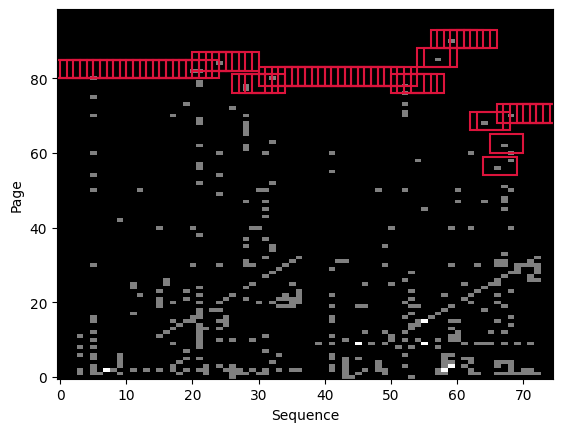

In [223]:
import matplotlib.pyplot as plt

# ...

def visualize_scores(possible_pages, scores, predictions):
    max_page = possible_pages['sequence'].max()
    max_possible_number = max_page + 25

    # Create a figure and axis for the visualization
    fig, ax = plt.subplots()

    # Display the scores as an image
    ax.imshow(scores.T, cmap='gray', origin='lower', aspect='auto')

    # Draw rectangles around the predicted pages
    for sequence, page in predictions:
        rect = plt.Rectangle((sequence - 2, page - 2), 5, 5, edgecolor='crimson', facecolor='none', linewidth=1.5)
        ax.add_patch(rect)

    # Set axis labels
    ax.set_xlabel('Sequence')
    ax.set_ylabel('Page')

    # Show the visualization
    plt.show()

# ...

# Call the visualization function
visualize_scores(possible_pages, raw_scores, predictions)


In [224]:


def visualize_scores_altair(possible_pages, scores, predictions):
    max_page = possible_pages['sequence'].max()
    max_possible_number = max_page + 25

    # Convert scores to a DataFrame
    scores_df = pd.DataFrame(scores)
    scores_df = scores_df.stack().reset_index()
    scores_df.columns = ['sequence', 'page', 'value']

    # Convert predictions to a DataFrame
    predictions_df = pd.DataFrame(predictions, columns=['sequence', 'page'])
    predictions_df['highlight'] = True

    # Calculate the width and height of the rectangles based on the heatmap grid
    width = (scores_df['sequence'].max() - scores_df['sequence'].min()) / len(scores)
    height = (scores_df['page'].max() - scores_df['page'].min()) / len(scores[0])

    # Create the base Altair chart
    base = alt.Chart(scores_df).encode(
        x=alt.X('sequence:Q', title='Sequence', scale=alt.Scale(padding=0.5*width)),
        y=alt.Y('page:Q', title='Page', scale=alt.Scale(padding=0.5*height))
    )

    # Create a heatmap for scores
    heatmap = base.mark_rect(width=width, height=height).encode(
        color=alt.Color('value:Q', scale=alt.Scale(scheme='greys'))
    )

    # Create a layer with red rectangles for predictions
    highlight = alt.Chart(predictions_df).mark_rect(width=width+2, height=height+2, stroke='crimson', strokeWidth=2).encode(
        x='sequence:Q',
        y='page:Q',
        color=alt.value('crimson'),
        opacity=alt.value(1),
        tooltip=['sequence', 'page']
    )

    # Combine the heatmap and highlight layers
    chart = heatmap + highlight

    return chart

# ...

# Call the visualization function
chart = visualize_scores_altair(possible_pages, raw_scores, predictions)
chart


alt.LayerChart(...)

In [145]:

from matplotlib.colors import LinearSegmentedColormap

class Matrix:
    def __init__(self, dims, fill=0, dtype=np.int16):
        self.dims = dims
        self.nrow = dims[0]
        self.ncol = dims[1]
        self.size = self.nrow * self.ncol
        self.dtype = dtype

        if hasattr(fill, '__iter__') and len(fill) > 1:
            if len(fill) != self.nrow * self.ncol:
                raise ValueError(f"Expecting a fill vector of length {self.size} but got a vector of length {len(fill)}")
            self.vals = np.array(fill, dtype=dtype).reshape(self.nrow, self.ncol)
        else:
            self.vals = np.full((self.nrow, self.ncol), fill, dtype=dtype)

    def add(self, matrix, balance=0.5):
        weights = [balance, 1 - balance]
        out = self.vals.copy()
        out = matrix.vals * weights[1] + self.vals * weights[0]
        return Matrix(self.dims, out)

    def set(self, i, j, val):
        self.vals[i, j] = val

    def get(self, i, j):
        return self.vals[i, j]

    def row(self, i):
        return self.vals[i]

    def col(self, j):
        return self.vals[:, j]

    def pprint(self):
        return self.vals

    def max(self):
        return self.vals.max()

    def clone(self):
        return Matrix(self.dims, self.vals.copy())

    def reverse(self):
        return Matrix(self.dims, np.flip(self.vals))

    def col_maxima(self):
        return np.argmax(self.vals, axis=1)

    def img(self, cmap_name='viridis', point_color='crimson', predictions=None):
        step = 2
        if self.nrow > plt.rcParams["figure.figsize"][0] * 2:
            step = 1

        max_val = self.max()
        fig, ax = plt.subplots()
        cmap = plt.get_cmap(cmap_name)
        colors = cmap(1 - self.vals / max_val)
        ax.imshow(colors, aspect='auto')

        if predictions:
            for seq, page in predictions:
                rect = plt.Rectangle((seq * step - 2, page * step - 2), step + 4, step + 4, edgecolor=point_color, facecolor='none', linewidth=2)
                ax.add_patch(rect)

        plt.show()

        return fig


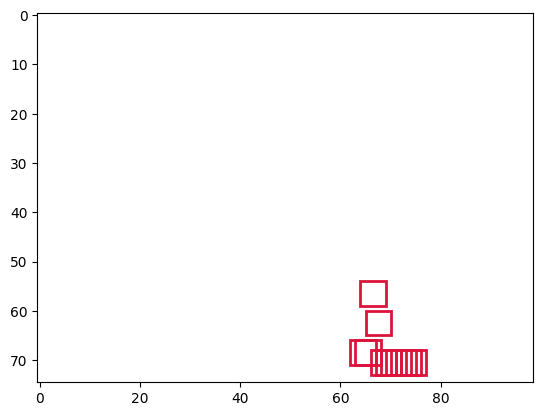

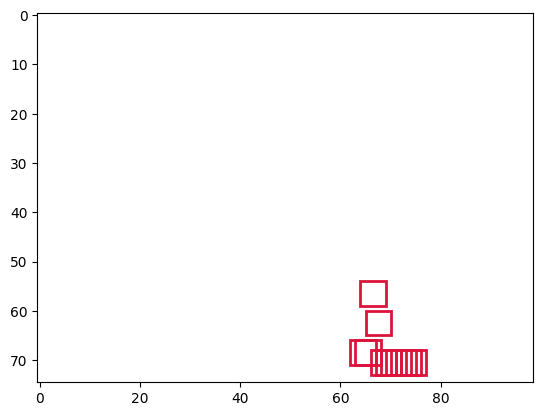

In [225]:
scores_matrix = Matrix(raw_scores.shape, fill=0)


scores_matrix.img(predictions=predictions)
